In [136]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
    
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [137]:
def split_datasets(X, y, test_size = 0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=12)
    return X_train, X_test, y_train, y_test

In [138]:
def plot_J(J_history):
    x = np.arange(0, len(J_history))
    plt.plot(x, J_history)
    plt.show()

In [139]:
def plot_feature_correlations(X):
    corrmat = X.corr()
    top_corr_features = corrmat.index
    sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [140]:
def plot_feature_scatters(X):
    sns.pairplot(X)

In [154]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier

def plot_feature_importance(X, y):
    # encoding 
    model = ExtraTreesClassifier()
    lab_enc = LabelEncoder()
    encoded = lab_enc.fit_transform(y)
    model.fit(X,encoded)
    #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.show()

In [142]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
# from sklearn.metrics import euclidean_distances

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

class CustomLinearRegressionEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, normalize=True):
        self.is_normalize = normalize
    
    def fit(self, X, y, alpha, num_iters):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        self.X_ = X
        self.y_ = y
        
        if self.is_normalize == True:
            X_norm, self.mean, self.std = self.normalize(self.X_)
            X = self.prepare_X(X_norm)
        else:
            X = self.prepare_X(self.X_)
        
        theta = np.zeros(X.shape[1])
        self.coef_, self.Js = self.gradient_descent(X, self.y_, theta, alpha, num_iters, False)
            
        return self
    
    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)
        
        # Input validation
        X = check_array(X)

        if self.is_normalize:
            X_norm = (X - self.mean) / self.std
            X_proc = self.prepare_X(X_norm)
            y_pred = self.hypothesis(X_proc, self.coef_)
        else:
            X_proc = self.prepare_X(X)
            y_pred = self.hypothesis(X_proc, self.coef_)

        return y_pred
    
    def get_cost_history(self):
        check_is_fitted(self)
        return self.Js
    
    def normalize(self, X):
        mean = np.mean(X)
        std = np.std(X)
        X_new = (X - mean)/std
        return X_new, mean, std
    
    def prepare_X(self, X):
        m = X.shape[0]
        ones = np.ones((m, 1))
        X_new = np.array(X[:])
        X_new = np.column_stack((ones, X_new))
        return X_new
    
    def derivative(self, X, y, theta):
        m = X.shape[0]

        d_theta = 1/m*(self.hypothesis(X, theta) - y).dot(X)
        return d_theta
    
    
    def cost_function(self, X, y, theta):
        m = X.shape[0]
        if m == 0:
            return None

        J = 1/(2*m) * sum((self.hypothesis(X, theta) - y) ** 2)
        return J
    
    def hypothesis(self, X, theta):
        h_thetha = np.dot(X, theta)
        return h_thetha
         
    def prepare_X(self, X):
        m = X.shape[0]
        ones = np.ones((m, 1))
        X_new = np.array(X[:])
        X_new = np.column_stack((ones, X_new))
        return X_new
        
    def gradient_descent(self, X, y, theta, alpha, num_iters, print_J = True):
        m = X.shape[0]
        J_history = []
        J = self.cost_function(X, y, theta)
        if print_J == True:
            print(J)
        J_history.append(J)
        for i in range(num_iters):
            delta = self.derivative(X, y, theta)
            theta = theta - alpha * delta
            J = self.cost_function(X, y, theta)
            
            if print_J == True:
                print(J)
            J_history.append(J)
        return theta, J_history


## Reading datasets

In [143]:
filename = "metacritic_games.csv"

x_features = ["metascore", "critic_negative", "critic_positive", "user_positive", "user_negative", "platform", "genre(s)"]
y_feature = ["user_score"]

data_features = x_features + y_feature

df = pd.read_csv(filename, delimiter=',')

df = df[(df['user_score'] != 'tbd')]
df["user_score"] = df["user_score"].astype(float)

#df = df.sample(100)
df = df[data_features]

X, y = df[x_features], df[y_feature]
print('Dataset: X={}, y={}'.format(X.shape, y.shape))
type(X)

Dataset: X=(17825, 7), y=(17825, 1)


pandas.core.frame.DataFrame

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17825 entries, 0 to 20421
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   metascore        17825 non-null  int64  
 1   critic_negative  17825 non-null  int64  
 2   critic_positive  17825 non-null  int64  
 3   user_positive    17825 non-null  int64  
 4   user_negative    17825 non-null  int64  
 5   platform         17825 non-null  object 
 6   genre(s)         17825 non-null  object 
 7   user_score       17825 non-null  float64
dtypes: float64(1), int64(5), object(2)
memory usage: 1.8+ MB


In [162]:
df.head()

,metascore,critic_negative,critic_positive,user_positive,user_negative,platform,genre(s),user_score
0,94,0,5,47,1,PC,Sci-Fi,8.9
1,86,0,6,18,0,PC,Adventure,8.7
2,69,0,1,1,1,PS,Action,5.8
3,94,0,7,46,1,PC,Strategy,8.9
4,94,0,9,84,1,PC,Action,8.8


## Categorizing and preprocessing

In [159]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer


cat = ["platform", "genre(s)"]
num = ["metascore", "critic_negative", "critic_positive", "user_positive", "user_negative"]


## ('scaler',  StandardScaler())
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent'))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(categories ='auto'))
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num),
    ('cat', cat_pipeline, cat)
])

print(df.head())

X_transformed = full_pipeline.fit_transform(X).toarray()

   metascore  critic_negative  critic_positive  user_positive  user_negative  \
0         94                0                5             47              1   
1         86                0                6             18              0   
2         69                0                1              1              1   
3         94                0                7             46              1   
4         94                0                9             84              1   

  platform   genre(s)  user_score  
0       PC     Sci-Fi         8.9  
1       PC  Adventure         8.7  
2       PS     Action         5.8  
3       PC   Strategy         8.9  
4       PC     Action         8.8  


## Splitting datasets

In [145]:
X_train, X_test, y_train, y_test = split_datasets(X_transformed, y, test_size=0.2)

y_train = np.array(y_train.iloc[:, 0])
y_test = np.array(y_test.iloc[:, 0])

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(14260, 90), y=(14260,)
Test set: X=(3565, 90), y=(3565,)


## Features scatter pairplots

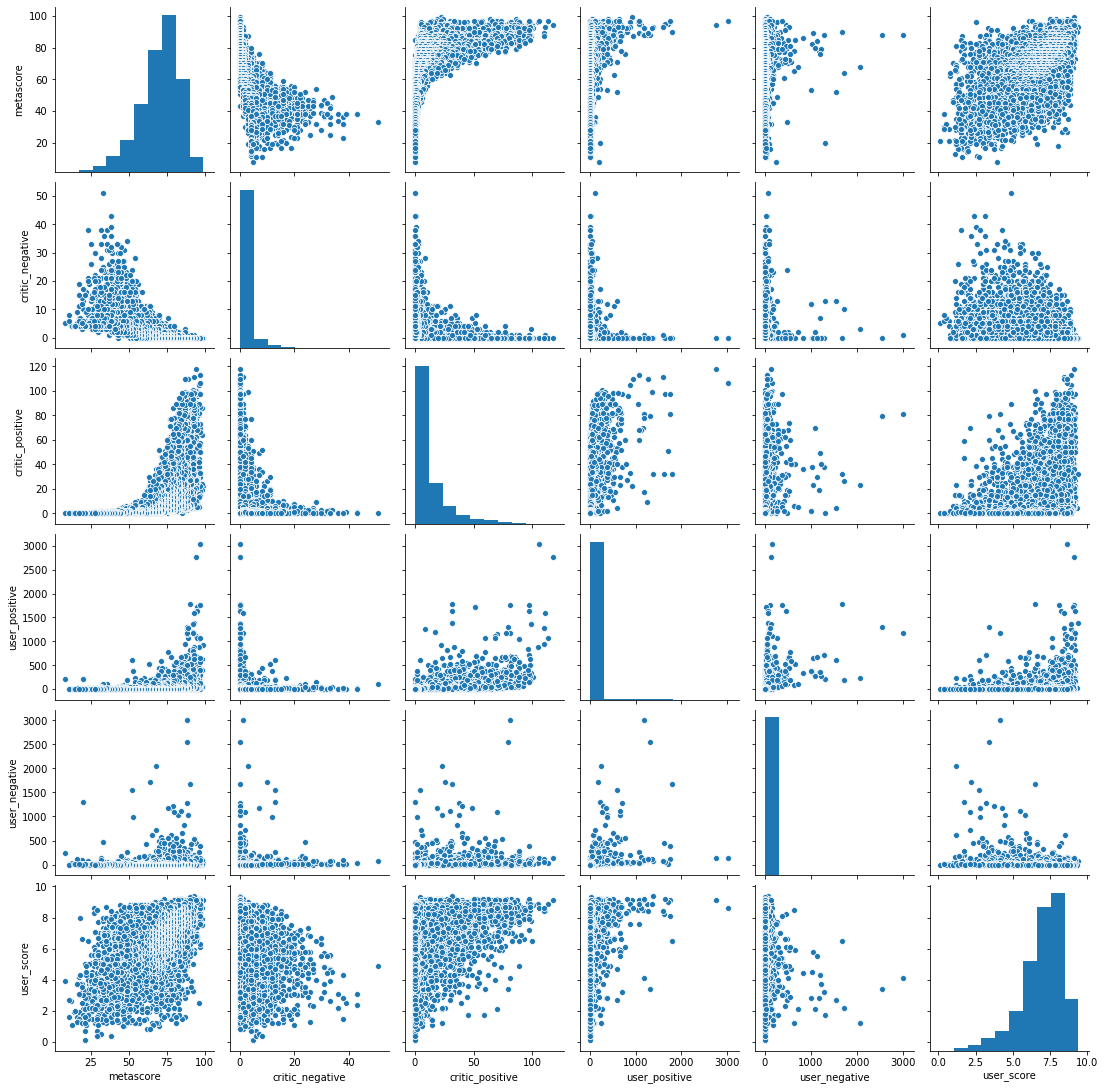

In [146]:
plot_feature_scatters(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025F8800CA88>,
      dtype=object)

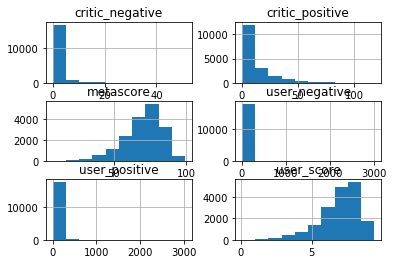

In [163]:
df.hist()

## Features correlation

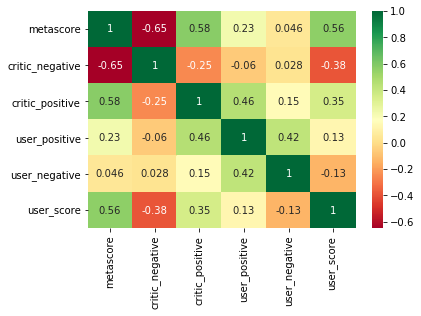

In [147]:
plot_feature_correlations(df)

## Custom Linear Regression Algorithm

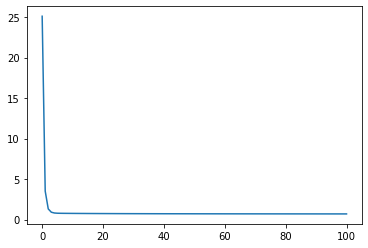

In [161]:
lg = CustomLinearRegressionEstimator(normalize=True)
# without normalization alpha ~ 0.0000001
# with normalization alpha ~ 0.03
lg.fit(X_train, y_train, 0.03, 100)
theta = lg.coef_

plot_J(lg.get_cost_history())

### Predicting on test detasets

In [149]:
y_test_pred = lg.predict(X_test)

rel_diff = np.abs(np.divide(y_test - y_test_pred, y_test)) * 100

res = pd.DataFrame({'y_actual' : y_test, 'y_pred' : y_test_pred.astype(int), 'err' : rel_diff})
print(res.head(20))

    y_actual  y_pred        err
0        7.1       7   3.085467
1        5.0       3  25.713924
2        6.6       6   1.960885
3        6.8       7  15.719539
4        7.1       6   2.288318
5        2.1       2  28.244270
6        8.0       7   5.069197
7        8.6       7  16.584142
8        7.8       6  11.111784
9        8.3       7   5.406003
10       7.4       7   0.841425
11       7.4       8  17.415861
12       8.4       7  10.530433
13       8.5       7   7.571045
14       6.5       6   0.524578
15       7.8       7   0.823235
16       8.8       8   4.482971
17       8.0       7  11.601853
18       7.2       6   6.879109
19       3.3       5  53.653249


### Custom Linear Regression Algorithm Deviations

In [150]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse = mean_squared_error(y_test, y_test_pred, squared=True)
mse = mean_squared_error(y_test, y_test_pred, squared=False)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

#print(f'Coefficients\n {theta}')
print(f'Root mean squared error: {rmse}')
print(f'Mean squared error: {mse}')
print(f'Mean absolute error: {mae}')
print(f'Coefficient of determination: {r2}')

Root mean squared error: 1.3841980749805782
Mean squared error: 1.1765194749686798
Mean absolute error: 0.8768453332031186
Coefficient of determination: 0.29320780199659446


## Sklearn Linear Regression Algorithm

In [151]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Sklearn Linear Regression Algorithm Deviations

In [152]:
y_pred = regr.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=True)
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
sk_r2 = r2_score(y_test, y_pred)

#print(f'Coefficients\n {regr.coef_}')
print(f'Root mean squared error: {rmse}')
print(f'Mean squared error: {mse}')
print(f'Mean absolute error: {mae}')
print(f'Coefficient of determination: {sk_r2}')
print(f'Difference: {r2 - sk_r2}')

Root mean squared error: 1.1033288237690693
Mean squared error: 1.05039460383661
Mean absolute error: 0.775400023650189
Coefficient of determination: 0.43662383399630555
Difference: -0.1434160319997111


## Feature Importance

c:\users\vsere\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


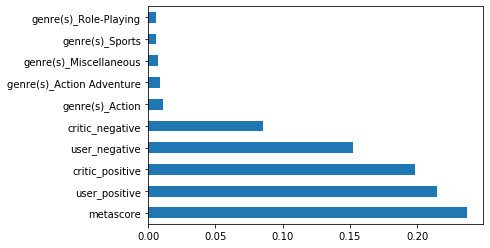

In [155]:
plot_feature_importance(pd.get_dummies(X), y)